In [57]:
import bs4 as bs
import datetime as dt
import os
import pandas as pd
import pandas_datareader as web
import pickle
import requests
import time
import matplotlib.pyplot as plt
from matplotlib import style
import numpy as np

style.use('ggplot')

In [2]:
def save_sp5_tickers():
    resp = requests.get('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
        
    with open("sp500tickers.pickle", 'wb') as f:
        pickle.dump(tickers, f)
    
    #print(tickers)
    
    return tickers

In [3]:
#save_sp5_tickers()

In [44]:
def get_data(reload_sp500=False):
    if reload_sp500:
        tickers = save_sp5_tickers()
    else:
        with open('sp500tickers.pickle', 'rb') as f:
            tickers = pickle.load(f)
    
    if not os.path.exists('stock_dfs'):
        os.makedirs('stock_dfs')
        
    start = dt.datetime(2015, 1, 1)
    end = dt.datetime(2017, 12, 31)
    
    for ticker in tickers:
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            try:
                df = web.DataReader(ticker, 'google', start, end)
                df.to_csv('stock_dfs/{}.csv'.format(ticker))
                time.sleep(60)
            except Exception as e:
                print('Error while getting data', ticker, e)
        else:
            print('Adready have {}'.format(ticker))

In [ ]:
get_data()

### Combining into one DataFrame

In [42]:
def compile_data():
    with open('sp500tickers.pickle', 'rb') as f:
        tickers = pickle.load(f)
        
    main_df = pd.DataFrame()
    
    for count, ticker in enumerate(tickers):
        if not os.path.exists('stock_dfs/{}.csv'.format(ticker)):
            continue
            
        df = pd.read_csv('stock_dfs/{}.csv'.format(ticker))
        df.set_index('Date', inplace=True)
        
        df.rename(columns={'Close': ticker}, inplace=True)
        df.drop(['Open', 'High', 'Low', 'Volume', 'Symbol'], 1, inplace=True)
        
        if main_df.empty:
            main_df = df
        else:
            main_df = main_df.join(df, how='outer')
            
        if count%10 == 0:
            print(count)
            
    print(main_df.head())
    main_df.to_csv('sp500_joined_closes.csv')

In [43]:
compile_data()

0
10
20
30
40
               MMM    ABT   ABBV    ACN    ATVI     AYI   ADBE   AMD     AAP  \
Date                                                                           
2015-01-01  164.32  45.02  65.44  89.31  20.150  140.07  72.70  2.67  159.28   
2015-01-02  164.06  44.90  65.89  88.84  20.130  139.88  72.34  2.69  158.56   
2015-01-05  160.36  44.91  64.65  87.34  19.850  136.52  71.98  2.66  156.47   
2015-01-06  158.65  44.40  64.33  86.71  19.480  134.81  70.53  2.63  156.36   
2015-01-07  159.80  44.76  66.93  88.53  19.055  137.20  71.11  2.58  159.72   

              AES   ...      AIG    AMT    AWK     AMP    ABC    AME    AMGN  \
Date                ...                                                        
2015-01-01  13.77   ...    56.01  98.85  53.30  132.25  90.16  52.63  159.29   
2015-01-02  13.70   ...    56.11  99.67  53.94  132.09  90.46  52.62  159.89   
2015-01-05  13.31   ...    55.00  98.23  53.11  127.85  89.69  51.04  157.99   
2015-01-06  13.01   ...  

### Correlation table

In [60]:
def visualize_data():
    df = pd.read_csv('sp500_joined_closes.csv')
    #df['APH'].plot()
    #plt.show()
    
    df_corr = df.corr()
    #print(df_corr)
    
    data = df_corr.values
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    heatmap = ax.pcolor(data, cmap=plt.cm.RdYlGn)
    fig.colorbar(heatmap)
    ax.set_xticks(np.arange(data.shape[0]) + 0.05, minor=False)
    ax.set_yticks(np.arange(data.shape[1]) + 0.05, minor=False)
    ax.invert_yaxis()
    ax.xaxis.tick_top()
    
    column_labels = df_corr.columns
    row_labels = df_corr.index
    
    ax.set_xticklabels(column_labels)
    ax.set_yticklabels(row_labels)
    
    plt.xticks(rotation=90)
    heatmap.set_clim(-1, 1)
    plt.tight_layout()
    plt.show()

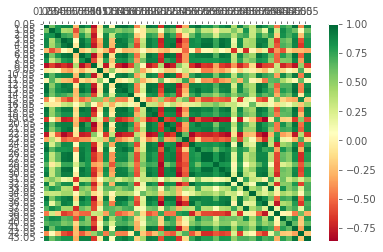

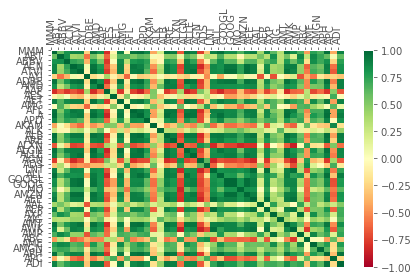

In [61]:
visualize_data()